<a href="https://colab.research.google.com/github/SicilianoBartolomeo/Sistemi-ad-agenti/blob/main/smartFallLstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

confronto con stato dell'arte (articoli su dataset)
valutare come sta fatto lo stato dell'arte
in caso siano uguali scegliere quello più efficiente in termini di classificazione

scrivere documentazione

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import collections 
import time
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [ ]:
np.random.seed(42)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
! unzip /content/gdrive/MyDrive/SmartFallDataSet.zip

Archive:  /content/gdrive/MyDrive/SmartFallDataSet.zip
   creating: SmartFallDataSet/
   creating: SmartFallDataSet/notch/
  inflating: SmartFallDataSet/notch/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/SmartFallDataSet/
   creating: __MACOSX/SmartFallDataSet/notch/
  inflating: __MACOSX/SmartFallDataSet/notch/._.DS_Store  
   creating: SmartFallDataSet/notch/Notch_Dataset_Wrist/
  inflating: SmartFallDataSet/notch/Notch_Dataset_Wrist/32ms_User3_LeftWrist.csv  
   creating: __MACOSX/SmartFallDataSet/notch/Notch_Dataset_Wrist/
  inflating: __MACOSX/SmartFallDataSet/notch/Notch_Dataset_Wrist/._32ms_User3_LeftWrist.csv  
  inflating: SmartFallDataSet/notch/Notch_Dataset_Wrist/32ms_User7_LeftWrist.csv  
  inflating: __MACOSX/SmartFallDataSet/notch/Notch_Dataset_Wrist/._32ms_User7_LeftWrist.csv  
  inflating: SmartFallDataSet/notch/Notch_Dataset_Wrist/32ms_User4_LeftWrist.csv  
  inflating: __MACOSX/SmartFallDataSet/notch/Notch_Dataset_Wrist/._32ms_User4_LeftWrist.csv  
  infla

In [ ]:
data_dir = "/workspace/inkyung/Fall Detection/"

train = pd.read_csv('/content/SmartFallDataSet/SmartWatch/raw182_Training_Relabeled_Auto_25.csv')
test = pd.read_csv('/content/SmartFallDataSet/SmartWatch/raw91_Testing_Relabeled_Auto_25.csv')

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/SmartFall Training.csv')
test = pd.read_csv('/content/gdrive/MyDrive/SmartFall Testing.csv')

In [ ]:
n = 40
X_train, y_train = list(), list()

for i in tqdm.notebook.tqdm(range(0, len(train)-40)):
    temp = list()
    
    temp.append(train[' ms_accelerometer_x'][i : i + n])
    temp.append(train[' ms_accelerometer_y'][i : i + n])
    temp.append(train[' ms_accelerometer_z'][i : i + n])
    
    cnt = collections.Counter(train['outcome'][i: i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]
    
    if num_fall == 25:
        y_train.append(1)
    else:
        y_train.append(0)
    
    X_train.append(temp)

  0%|          | 0/92741 [00:00<?, ?it/s]

In [ ]:
n = 40
X_test_adl, X_test_fall, y_test_adl, y_test_fall = list(), list(), list(), list()
for i in tqdm.notebook.tqdm(range(0, len(test) - 40)):
    temp = list()
    
    temp.append(test[' ms_accelerometer_x'][i : i + n])
    temp.append(test[' ms_accelerometer_y'][i : i + n])
    temp.append(test[' ms_accelerometer_z'][i : i + n])
    
    cnt = collections.Counter(test['outcome'][i : i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]
    
    if num_fall == 25:
        y_test_fall.append(1)
        X_test_fall.append(temp)
    else:
        y_test_adl.append(0)
        X_test_adl.append(temp)

  0%|          | 0/90985 [00:00<?, ?it/s]

In [ ]:
print(len(y_test_fall))
print(len(y_test_adl))

3216
87769


In [ ]:
# to keep the balance between ADL and FALL data, used only part of ADL data

X_test_adl = X_test_adl[:3216]
y_test_adl = y_test_adl[:3216]

y_test = y_test_adl + y_test_fall
X_test = X_test_adl + X_test_fall

In [ ]:
print('length of test data', len(X_test))

length of test data 6432


In [ ]:
print('train data adl and fall ratio')
print('--------------------------------')
cnt_train = collections.Counter(y_train)
print('train data adl ratio: ', cnt_train[0])
print('train data fall ratio: ', cnt_train[1])
print('--------------------------------')

cnt_test = collections.Counter(y_test)
print('test data adl ratio: ', cnt_test[0])
print('test data fall ratio: ', cnt_test[1])

train data adl and fall ratio
--------------------------------
train data adl ratio:  87509
train data fall ratio:  5232
--------------------------------
test data adl ratio:  3216
test data fall ratio:  3216


In [ ]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [ ]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

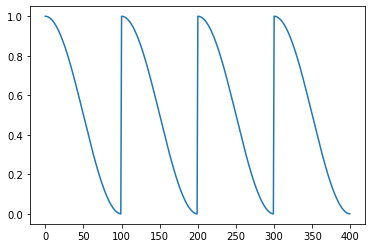

In [ ]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(self.relu(out[:, -1]))
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [ ]:
X_train = np.asarray(X_train).reshape(-1, 40, 3)
y_train = np.asarray(y_train).reshape(-1, )

X_test = np.asarray(X_test).reshape(-1, 40, 3)
y_test = np.asarray(y_test).reshape(-1, )

In [ ]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [ ]:
batch_size = 128

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True, batch_size=batch_size)

valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
valid_loader = torch.utils.data.DataLoader(
    valid_data,
    shuffle=True, batch_size=batch_size)

test_data =TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True, batch_size=batch_size)

In [ ]:
input_dim = next(iter(train_loader))[0].shape[2]
output_dim = 2
n_layers = 2
hidden_dim = 256

lr = 0.0001
n_epochs = 40
iterations_per_epoch = len(train_loader)
best_acc = 0.
patience, trials = 15, 0

model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers).cuda()
print(model)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
sched = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min = lr/10))
epoch_times = []

LSTMNet(
  (lstm): LSTM(3, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)


In [ ]:
print('Start model training')
train_loss, train_acc = list(), list()
for epoch in range(1, n_epochs + 1):
    start_time = time.process_time()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        model.train()
        X_batch = X_batch.float().cuda()
        y_batch = y_batch.cuda()
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        sched.step()
    current_time = time.process_time()
    epoch_times.append(current_time-start_time)
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in valid_loader:
        x_val, y_val = [t.cuda() for t in (x_val.float(), y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
        
    acc = correct / total
    
    train_loss.append(loss.item())
    train_acc.append(acc)
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')
        
    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'SmartFall_lstm.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
print("Total Training Time: {} seconds".format(str(sum(epoch_times))))

Start model training
Epoch 1 best model saved with accuracy: 94.27%
Epoch 3 best model saved with accuracy: 96.56%
Epoch 4 best model saved with accuracy: 97.04%
Epoch:   5. Loss: 0.0011. Acc.: 97.55%
Epoch 5 best model saved with accuracy: 97.55%
Epoch 6 best model saved with accuracy: 97.70%
Epoch 7 best model saved with accuracy: 97.81%
Epoch 8 best model saved with accuracy: 98.07%
Epoch:  10. Loss: 0.0023. Acc.: 98.31%
Epoch 10 best model saved with accuracy: 98.31%
Epoch 12 best model saved with accuracy: 98.44%
Epoch 14 best model saved with accuracy: 98.45%
Epoch:  15. Loss: 0.0031. Acc.: 98.35%
Epoch 16 best model saved with accuracy: 98.51%
Epoch 19 best model saved with accuracy: 98.56%
Epoch:  20. Loss: 0.0145. Acc.: 98.52%
Epoch 22 best model saved with accuracy: 98.60%
Epoch 24 best model saved with accuracy: 98.75%
Epoch:  25. Loss: 0.1208. Acc.: 98.62%
Epoch:  30. Loss: 0.0009. Acc.: 98.80%
Epoch 30 best model saved with accuracy: 98.80%
Epoch 32 best model saved with a

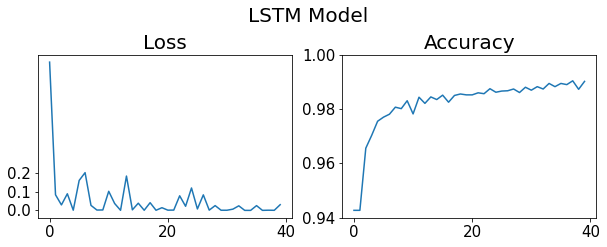

In [ ]:
plt.figure(figsize=(10, 3))
plt.suptitle('LSTM Model', fontsize=20, y=1.1)
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_loss)), train_loss)
plt.yticks([0.0, 0.10, 0.20], fontsize=15)
plt.xticks([0, 20, 40], fontsize=15)
plt.title('Loss', fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(train_acc)), train_acc)
plt.yticks([0.94, 0.96, 0.98, 1.0],fontsize=15)
plt.xticks([0, 20, 40], fontsize=15)
plt.title('Accuracy',fontsize=20)
plt.subplots_adjust(hspace=1)

plt.show()

In [ ]:
# evaluation with test dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

targets = list()
preds = list()
correct = 0
model.load_state_dict(torch.load('SmartFall_lstm.pth'))
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.cuda(), y.cuda()
        output = model(X.float())
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()

        targets += list(y.cpu().numpy())
        preds += list(pred.cpu().numpy())

test_acc = 100. * correct / len(test_loader.dataset)
confusion_mtx = confusion_matrix(targets, preds)
print(test_acc)

92.64614427860697


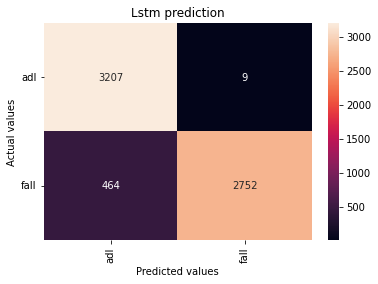

In [ ]:
import seaborn
classes = ['adl','fall']
ax = seaborn.heatmap(confusion_mtx, annot=True, fmt='d')
ax.set_title("Lstm prediction")
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')

ax.xaxis.set_ticklabels(classes, rotation=90)
ax.yaxis.set_ticklabels(classes, rotation=0)


plt.show()

In [ ]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3216
           1       1.00      0.86      0.92      3216

    accuracy                           0.93      6432
   macro avg       0.94      0.93      0.93      6432
weighted avg       0.94      0.93      0.93      6432



In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

print('F1:' ,f1_score(targets, preds))
print('Recall:' ,recall_score(targets, preds))
print('Precision' ,precision_score(targets, preds))

F1: 0.9208633093525179
Recall: 0.8557213930348259
Precision 0.9967403114813473
